In [148]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy
from collections import namedtuple

In [149]:
num_stairs = 10
num_examples = 10
adv_eps = (1.0 / 3)
noise_eps = 0.0
x_noise = 0.0
slope = 1
theta = np.random.randn(feats.shape[1])
lamda = 0.01
np.set_printoptions(precision=5)

knots = np.r_[np.arange(num_stairs), np.arange(num_stairs)-adv_eps, np.arange(num_stairs)+adv_eps]
knots = np.sort(knots)

# weights on different stairs
weights_1 = np.asarray([1/5]*5)
weights_2 = np.asarray([0.01]*(num_stairs-5))
weights = np.concatenate([weights_1, weights_2])
weights /= np.sum(weights)

Result = namedtuple('Result', ['x'])

In [150]:
def generate_x_noise(n):    
    # with probability x_noise there is noise
    unit_noise = (np.random.rand(n) < 0.5).astype(float)
    noise_mask = (np.random.rand(n) < x_noise).astype(float)
    return noise_mask * (unit_noise*2 - 1)*adv_eps

def data_gen(n, weights):
    num_stairs = len(weights)
    # sample from categorical distribution
    X = np.random.choice(num_stairs, p=weights, size=n).astype(float)
    return X

def label_noise(n, eps):
    return eps * np.random.randn(n)

def get_test_set():
    num_samples_per_stair = 10000
    # X_test has every row a different class and columns are samples from that class
    y_test = slope*np.arange(num_stairs).astype(float)[:, np.newaxis] * np.ones((num_stairs, num_samples_per_stair))
    X_test = np.arange(num_stairs).astype(float)[:, np.newaxis]
    noise = (np.random.rand(num_stairs, num_samples_per_stair)*2 - 1)*adv_eps
    X_test = X_test + noise
    return X_test, y_test

def get_feats(X, knots):
    X = X[:, np.newaxis]
    M = 4
    aug = np.arange(1, M+1)
    knots = np.r_[aug - M - 1 - knots[0], knots, aug + knots[-1]]

    K = len(knots)
    bases = (X >= knots[:-1]).astype(np.int) * (X < knots[1:]).astype(np.int)
    # do recursion from Hastie et al. vectorized
    maxi = len(knots) - 1
    for m in range(2, M+1):
        maxi -= 1

        # left sub-basis
        num = (X - knots[:maxi])* bases[:, :maxi]
        denom = knots[m-1 : maxi+m-1] - knots[:maxi]
        left = num/denom

        # right sub-basis
        num = (knots[m : maxi+m] - X) * bases[:, 1:maxi+1]
        denom = knots[m:maxi+m] - knots[1 : maxi+1]
        right = num/denom

        bases = left + right
    return bases


In [151]:
def sqerr(theta): 
    return np.square(feats.dot(theta) - y).sum()

def sparse_diff(array, n=1, axis=-1):                                                                                                                 
    if (n < 0) or (int(n) != n):                                                
        raise ValueError('Expected order is non-negative integer, '             
                         'but found: {}'.format(n))                             
    if not scipy.sparse.issparse(array):                                        
        warnings.warn('Array is not sparse. Consider using numpy.diff')         
                                                                                
    if n == 0:                                                                  
        return array                                                            
                                                                                
    nd = array.ndim                                                             
    slice1 = [slice(None)]*nd                                                   
    slice2 = [slice(None)]*nd                                                   
    slice1[axis] = slice(1, None)                                               
    slice2[axis] = slice(None, -1)                                              
    slice1 = tuple(slice1)                                                      
    slice2 = tuple(slice2)                                                      
                                                                                
    A = sparse_diff(array, n-1, axis=axis)                                      
    return A[slice1] - A[slice2]  

def derivative(n, order=2):                                                     
    if n == 1:                                                                  
        # no derivative for constant functions                                  
        return scipy.sparse.csc_matrix(0.)                                      
    D = sparse_diff(scipy.sparse.identity(n).tocsc(), n=order).tolil()          
    return np.asarray(D.dot(D.T).tocsc().todense()) 

def get_P(knots, with_intercept=False):
    P = derivative(len(knots) + 4, order=2) 
    return P

def norm(theta):
    return P.dot(theta).dot(theta)

def T(x):
    x_round = np.round(x)
    return [x_round-adv_eps, x_round,  x_round+adv_eps]
    
def sqerr_adv(theta, T_feats):
    sqerrs = [np.square(dat.dot(theta) - y) for dat in T_feats]
    max_errs = np.sum(np.maximum.reduce(sqerrs))
    return max_errs

def test_sqerr(theta): 
    def err_y_for_x(x, e_y):                                                    
        x_feats = get_feats(np.asarray([x]), knots)                             
        preds_x = x_feats.dot(theta)[0]                                         
        err_for_pt = np.square(preds_x) - 2*preds_x*e_y + noise_eps**2 + np.square(e_y)
        return err_for_pt                                                       
                                                                                
    total_err = []                                                              
    for i in range(X_test.shape[0]):                                                                                                            
        class_i_err = 0                                                     
        for x in [i-adv_eps, i+adv_eps]:                                    
            class_i_err += 0.5 * x_noise * err_y_for_x(x, slope*i)                                                                
        class_i_err += (1-x_noise)*err_y_for_x(i, slope*i)                      
        total_err.append(class_i_err)                                           
    total_err = np.asarray(total_err)                                           
    return np.sum(total_err * weights) 

def summarize(res, X):
    T_feats = [get_feats(xx, knots) for xx in [X, X-adv_eps, X+adv_eps]]
    theta = res.x
    print("sq err train")
    print(sqerr(theta)/X.shape[0])
    print("sq err adv train")
    print(sqerr_adv(theta, T_feats)/X.shape[0])
    print("sq err test")
    print(test_sqerr(theta))
    print("generalization gap")
    print(test_sqerr(theta) - sqerr(theta)/X.shape[0])
    print("rkhs norm")
    print(norm(theta))

In [152]:
def solve_normal(f_mat, labels, l):
    mat = f_mat.T.dot(f_mat) + l * get_P(knots)
    theta = np.linalg.pinv(mat).dot(f_mat.T.dot(labels))
    res_normal = Result(x=theta)
    return res_normal

def solve_adv(T_feats, y, lamda, P):
    theta_var = cp.Variable(T_feats[0].shape[1])
    sum_sq = [cp.square(dat*theta_var - y) for dat in T_feats]
    objective = cp.Minimize(cp.sum(reduce(cp.maximum, sum_sq)) + lamda*cp.quad_form(theta_var, P))
    prob = cp.Problem(objective)
    prob.solve()
    return Result(x=theta_var.value)

In [153]:
P = get_P(knots)

X = data_gen(num_examples, weights)
y = slope*X + label_noise(X.shape[0], noise_eps)
X += generate_x_noise(num_examples)

X_test, y_test = get_test_set()
    
feats = get_feats(X, knots)
print(feats.shape)
res_normal = solve_normal(feats, y, lamda)

(10, 34)


In [154]:
# adversarial training data
T_feats = [get_feats(xx, knots) for xx in [X-adv_eps, X, X+adv_eps]]

# robust self training data
X_unlabeled = data_gen(200, weights)
feats_unlabeled = get_feats(X_unlabeled, knots)
y_unlabeled = feats_unlabeled.dot(res_normal.x)
X_aug = np.concatenate([X, X_unlabeled])
y_aug = np.concatenate([y, y_unlabeled])
T_feats_aug = [get_feats(xx, knots) for xx in [X_aug-adv_eps, X_aug, X_aug+adv_eps]]

res_adv = solve_adv(T_feats, y, lamda, P)
res_rst = solve_adv(T_feats_aug, y_aug, lamda, P)

Normal
sq err train
8.185476708662828e-30
sq err adv train
0.11111111111112745
sq err test
4.7031158142239e-06
generalization gap
4.7031158142239e-06
rkhs norm
-2.2019423318376158e-14

Adversarial
sq err train
0.0019194515382713207
sq err adv train
0.00706729566536512
sq err test
0.1543837475112431
generalization gap
0.15246429597297176
rkhs norm
15.305814769496104


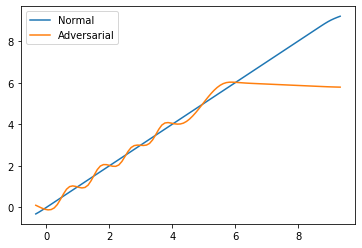

In [155]:
X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(res_normal.x)

plt.plot(X_plot, normal_plot_preds, label="Normal")
adv_plot_preds = feats_plot.dot(res_adv.x)
plt.plot(X_plot, adv_plot_preds, label="Adversarial")
plt.legend()
print("Normal")
summarize(res_normal, X)
print()
print("Adversarial")
summarize(res_adv, X)

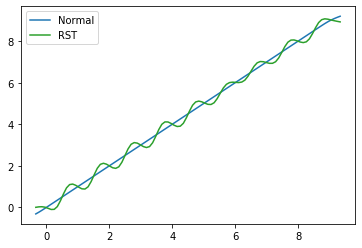

In [156]:
plt.plot(X_plot, normal_plot_preds, label="Normal")
rst_plot_preds = feats_plot.dot(res_rst.x)
plt.plot(X_plot, rst_plot_preds, label="RST", c='C2')
plt.legend()